# Secrets behind recipes

Team member: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0 Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import inflect 
from wordcloud import WordCloud, STOPWORDS 

In [2]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [3]:
recipe.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


---

# 1 Data cleaning

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents.

In the end, we get 93872 rows of recipes with country labeled.

In [5]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [6]:
recipe['tags'] = recipe['tags'].apply(ast.literal_eval)

In [7]:
recipe_tag = recipe.explode('tags')

In [8]:
recipe_tag['tags'].unique()

array(['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient',
       'cuisine', 'preparation', 'occasion', 'north-american',
       'side-dishes', 'vegetables', 'mexican', 'easy', 'fall',
       'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas',
       'seasonal', 'squash', '30-minutes-or-less', 'breakfast',
       'main-dish', 'pork', 'american', 'oven', 'kid-friendly', 'pizza',
       'northeastern-united-states', 'meat', 'equipment', 'chili',
       'crock-pot-slow-cooker', '4-hours-or-less', 'eggs-dairy',
       'potatoes', 'dinner-party', 'easter', 'cheese', 'stove-top',
       'new-years', 'thanksgiving', 'independence-day', 'st-patricks-day',
       'valentines-day', 'inexpensive', 'brunch', 'superbowl',
       'presentation', 'served-hot', 'weeknight', 'canning',
       'condiments-etc', 'heirloom-historical', 'amish-mennonite',
       'number-of-servings', 'technique', '15-minutes-or-less',
       'low-protein', '5-ingredients-or-less', 'beverages', '

In [280]:
union = ['austrilian', 'chinese', 'korean','american', 
               'japanese', 'thai', 'italian', 'french', 'danish', 
               'swiss', 'swedish','german', 'namibian', 'argentine', 'nigerian', 'norwagian',
             'new-zealand', 'lebanese','mexican', 'irish', 'canadian', 'hawaiian', 
             'indonesian', 'polish', 'caribbean', 'russian', 'iraqi', 'saudi-arabian', 'pakistani', 'scottish',
             'south-african', 'cuban', 'columbian', 'finnish', 'iranian-persian', 'dutch', 'turkish', 
              'portuguese', 'hungarian', 'georgian','brazilian', 'nigerian',  'egyptian', 'chilean',
             'vietnamese', 'palestinian', 'austrian', 'caribbean', 'greek', 'micro-melanesia','polynesian',
             'spanish', 'malaysian', 'namibian', 'angolan','belgian', 'cambodian','british-columbian',
        'californian', 'cantonese', 'central-american', 'chinese-new-year', 'costa-rican', 'czech',
    'ethiopian','filipino','honduran','hunan','icelandic',  'irish-st-patricks-day','laotian',
    'libyan', 'mongolian','moroccan','native-american',
    'north-american','northeastern-united-states','oaxacan', 'ontario', 'quebec','puerto-rican', 'somalian', 
    'southern-united-states','sudanese', 'szechuan','welsh', 'venezuelan', 'indian']

In [281]:
dic = {'mexican': 'Mexico',
'american': 'America',
'canadian': 'Canada',
'hawaiian': 'Hawaii',
'german': 'Germany',
'italian': 'Italy',
'polish': 'Poland',
'danish': 'Denmark',
'swiss': 'Switzerland',
'swedish': 'Sweden',
'caribbean': 'Caribbean',
'greek': 'Greece',
'russian': 'Russia',
'micro-melanesia': 'Melanesia',
'spanish': 'Spain',
'irish': 'Ireland',
'scottish': 'UK',
'south-african': 'South Africa',
'new-zealand': 'New Zealand',
'finnish': 'Finland',
'dutch': 'Netherlands',
'portuguese': 'Portugal',
'hungarian': 'Hungary',
'brazilian': 'Brazil',
'nigerian': 'Niger',
'egyptian': 'Egypt',
'argentine': 'Argentina',
'chilean': 'Chile',
'chinese': 'China',
'saudi-arabian': 'Saudi Arabia',
'turkish': 'Turkey',
'japanese': 'Japan',
'austrian': 'Austria',
'palestinian': 'Palestine',
'lebanese': 'Lebanon',
'thai': 'Thailand',
'indonesian': 'Indonesia',
'italian': 'Italy',
'pakistani': 'Pakistan',
'cuban': 'Cuba',
'malaysian': 'Malaysia',
'vietnamese': 'Vietnam',
'palestinian': 'Palestine',
'namibian': 'Namibia',
'iranian-persian': 'Iran',
'polynesian': 'Polynesia',
'iraqi': 'Iraq',
'georgian': 'Georgia',
'korean': 'Korea',
'french': 'France' ,
'english': 'England',
'austrilian': 'Austrilia',
'norwagian': 'Norway',
'angolan': 'Angola',
'belgian': 'Belgium', 
'cambodian': 'Cambodia',
'british-columbian': 'Canada', 
'californian': 'America', 
'cantonese': 'China', 
'central-american': 'America', 
'chinese-new-year': 'China', 
'costa-rican': 'Costa Rica', 
'czech': 'Czechia',
'ethiopian': 'Ethiopia',
'filipino': 'Philippines',
'honduran': 'Honduras',
'hunan': 'China',
'icelandic': 'Iceland',  
'irish-st-patricks-day': 'Ireland',
'laotian': 'Lao',
'libyan': 'Lybia', 
'mongolian': 'Mongolia',
'moroccan': 'Morocca',
'native-american': 'America',
'north-american': 'America',
'northeastern-united-states': 'America',
'oaxacan': "Mexico", 
'ontario': 'Canada', 
'quebec': 'Canada',
'puerto-rican': 'Caribbean', 
'somalian': 'Somalia', 
'southern-united-states': 'America', 
'sudanese': 'Sudan', 
'szechuan': 'China',
'welsh': 'UK', 
'venezuelan': 'Venezuela',
'indian': 'India'}


In [282]:
dic_cc = {'Mexico': 'North America',
'America':'North America',
'Canada':'North America',
'Hawaii':'North America',
'Germany': 'Europe',
'Italy':'Europe',
'Poland':'Europe',
'Denmark':'Europe',
'Switzerland':'Europe',
'Sweden':'Europe',
'Caribbean':'North America',
'Greece':'Europe',
'Russia':'Europe',
'Melanesia':'Oceania',
'Spain':'Europe',
'Ireland':'Europe',
'UK':'Europe',
'South Africa':'Africa',
'New Zealand':'Oceania',
'Finland':'Europe',
'Netherlands':'Europe',
'Portugal':'Europe',
'Hungary':'Europe',
'Brazil':'South America',
'Niger':'Africa',
'Egypt': 'Africa',
'Argentina': 'South America',
'Chile':'South America',
'China':'Asia',
'Saudi Arabia': 'Asia',
'Turkey':'Asia',
'Japan':'Asia',
'Austria':'Europe',
'Palestine':'Asia',
'Lebanon':'Asia',
'Thailand':'Asia',
'Indonesia':'Asia',
'Pakistan':'Asia',
'Cuba':'South America',
'Malaysia':'Asia',
'Vietnam':'Asia',
'Namibia':'Africa',
'Iran':'Asia',
'Polynesia': 'Oceania',
'Iraq':'Asia',
'Georgia':'Europe',
'Korea':'Asia',
'France' :'Europe',
'England':'Europe',
'Austrilia':'Oceania',
'Norway': 'Europe',
'Angola': 'Africa',
'Belgium': 'Europe',
'Cambodia': 'Asia',
'Costa Rica': 'North America',
'Czechia': 'Europe',
'Ethiopia': 'Africa',
'Philippines': 'Asia',
'Honduras': 'North America',
'Iceland': 'Europe',
'Lao': 'Asia',
'Lybia': 'Africa',
'Mongolia': 'Asia',
'Morocca': 'Africa',
'Somalia': 'Africa', 
'Venezuela': 'South America',
'Sudan': 'Africa',
'India': 'Asia'
}

In [283]:
recipe_country =  recipe_tag[recipe_tag['tags'].isin(union)]

In [284]:
recipe_country.insert(2, "country", recipe_country['tags'].map(dic), True) 

In [285]:
recipe_country.drop(columns = 'tags', inplace=True)

/Users/tianyangdong/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [286]:
recipe_country.reset_index(drop = True, inplace = True)
recipe_country.drop_duplicates(inplace = True)

/Users/tianyangdong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [287]:
recipe_country.insert(3, "continent", recipe_country['country'].map(dic_cc), True) 

In [288]:
recipe_country

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
5,amish tomato ketchup for canning,44061,America,North America,190,41706,2002-10-25,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
8,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139611,zwiebeln salat swiss onion salad,455209,Switzerland,Europe,10,1058097,2011-05-05,"[113.5, 11.0, 17.0, 19.0, 2.0, 24.0, 3.0]",5,"['melt butter in a saucepan', 'add onions and ...",adapted from pan american's compete round the ...,"['butter', 'onions', 'flour', 'salt', 'vinegar']",5
139612,zwiebelsuppe clear german onion soup,61748,Germany,Europe,35,27783,2003-05-08,"[252.0, 17.0, 21.0, 44.0, 21.0, 14.0, 7.0]",10,"['heat oil in a large pot', 'saute garlic slic...",this is very different from french onion soup....,"['onions', 'red onions', 'fresh garlic', 'oliv...",11
139613,zwiebelwhe swiss onion tart,410985,Switzerland,Europe,165,993604,2010-01-30,"[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13
139614,zydeco sauce,357451,America,North America,15,461283,2009-02-23,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"['to make the sauce , combine the mayonnaise ,...",great sauce for cheeseburgers or dipping fries...,"['mayonnaise', 'prepared horseradish', 'worces...",6


In [289]:
recipe_country.to_pickle('recipe_country.pkl')

## 1.2 Classify recipes by meal types

To better understand the difference between countires and regions, we divide the recipes into classes: main dish, side dish, dessert, appetizer, soup, beverage, cake style (bread, sandwich and cake), sauce, salad and snack. These classes are not mutually exclusive, so there may be a recipe in two classes at the same time. The information about dish type is gained from tags of recipes.

This type specified dataframe will be used later for analyzing the ingredients and answer questions like: what is the most frequently used meat for main dish in each country?

In [290]:
main_dish = recipe_tag[recipe_tag['tags'].str.contains('main-dish')][['id', 'tags']]

In [291]:
main_dish.rename(columns = {'tags':'main_dish'}, inplace = True)

In [292]:
side_dish = recipe_tag[recipe_tag['tags'].str.contains('side-dishes')][['id', 'tags']]
side_dish.rename(columns = {'tags':'side_dish'}, inplace = True)

In [293]:
dessert = recipe_tag[recipe_tag['tags'].str.contains('dessert')][['id', 'tags']]
dessert.rename(columns = {'tags':'dessert'}, inplace = True)

In [294]:
appetizer = recipe_tag[recipe_tag['tags'].str.contains('appetizer')][['id', 'tags']]
appetizer.rename(columns = {'tags':'appetizer'}, inplace = True)

In [295]:
soup = recipe_tag[recipe_tag['tags'].str.contains('soup|stew')][['id', 'tags']]
soup.rename(columns = {'tags':'soup'}, inplace = True)

In [296]:
beverage = recipe_tag[recipe_tag['tags'].str.contains('beverage')][['id', 'tags']]
beverage.rename(columns = {'tags':'beverage'}, inplace = True)

In [297]:
cake_style = recipe_tag[recipe_tag['tags'].str.contains('sandwich|bread|cake')][['id', 'tags']]
cake_style.rename(columns = {'tags':'cake_style'}, inplace = True)

In [298]:
sauce = recipe_tag[recipe_tag['tags'].str.contains('sauce')][['id', 'tags']]
sauce.rename(columns = {'tags':'sauce'}, inplace = True)

In [299]:
salad = recipe_tag[recipe_tag['tags'].str.contains('salad')][['id', 'tags']]
salad.rename(columns = {'tags':'salad'}, inplace = True)

In [300]:
snack = recipe_tag[recipe_tag['tags'].str.contains('snack')][['id', 'tags']]
snack.rename(columns = {'tags':'snack'}, inplace = True)

In [301]:
recipe_s = recipe_country.merge(main_dish, on = 'id', how = 'left'
                    ).merge(side_dish, on = 'id', how = 'left').merge(dessert, on = 'id', how = 'left',
                    ).merge(appetizer, on = 'id', how = 'left').merge(soup, on = 'id', how = 'left'
                                            ).merge(beverage, on = 'id', how = 'left'
                                                   ).merge(cake_style, on = 'id', how = 'left'
                                                          ).merge(sauce, on = 'id', how = 'left'
                                         ).merge(salad, on = 'id', how = 'left').merge(
                                                snack, on = 'id', how = 'left')

In [302]:
recipe_s['main_dish'] = recipe_s['main_dish'].notnull().astype('int')

In [303]:
recipe_s['side_dish'] = recipe_s['side_dish'].notnull().astype('int')
recipe_s['dessert'] = recipe_s['dessert'].notnull().astype('int')
recipe_s['appetizer'] = recipe_s['appetizer'].notnull().astype('int')

In [304]:
recipe_s['soup'] = recipe_s['soup'].notnull().astype('int')
recipe_s['beverage'] = recipe_s['beverage'].notnull().astype('int')

In [305]:
recipe_s['cake_style'] = recipe_s['cake_style'].notnull().astype('int')

In [306]:
recipe_s['sauce'] = recipe_s['sauce'].notnull().astype('int')
recipe_s['salad'] = recipe_s['salad'].notnull().astype('int')
recipe_s['snack'] = recipe_s['snack'].notnull().astype('int')

In [307]:
recipe_s.drop_duplicates(inplace = True)

In [308]:
recipe_s.shape

(93872, 23)

The recipes that are not labeled among the given classes are deleted. 84301 rows are left.

In [309]:
recipe_split = recipe_s[recipe_s.iloc[:, 13:].sum(axis = 1) > 0]

In [310]:
recipe_split

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,...,main_dish,side_dish,dessert,appetizer,soup,beverage,cake_style,sauce,salad,snack
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",...,0,1,0,0,0,0,0,0,0,0
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",...,0,1,0,0,0,0,0,0,0,0
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",...,1,0,0,0,0,0,0,0,0,0
4,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",...,0,0,0,0,0,1,0,0,0,0
5,aww marinated olives,25274,America,North America,15,21730,2002-04-14,"[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101427,zwiebeln salat swiss onion salad,455209,Switzerland,Europe,10,1058097,2011-05-05,"[113.5, 11.0, 17.0, 19.0, 2.0, 24.0, 3.0]",5,"['melt butter in a saucepan', 'add onions and ...",...,0,0,0,1,0,0,0,0,1,0
101428,zwiebelsuppe clear german onion soup,61748,Germany,Europe,35,27783,2003-05-08,"[252.0, 17.0, 21.0, 44.0, 21.0, 14.0, 7.0]",10,"['heat oil in a large pot', 'saute garlic slic...",...,0,0,0,0,1,0,0,0,0,0
101430,zwiebelwhe swiss onion tart,410985,Switzerland,Europe,165,993604,2010-01-30,"[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",...,1,1,0,0,0,0,0,0,0,0
101431,zydeco sauce,357451,America,North America,15,461283,2009-02-23,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"['to make the sauce , combine the mayonnaise ,...",...,0,0,0,0,0,0,0,1,0,0


## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients need by the recipe are listed. To learn in detail about each country's eating habits, we investigate two aspects of the ingredients: seasoning and main ingredients. Here we  refer seasoning as those that are used to adjust the flavor of the dish, like curry, parsley and so on. While main ingredients are those that are added in the dish for the purpose of eating, e.g. beef, egg. The extraction of main ingredients are done in Section 1.5

The seasoning list is collceted through searching on Google. 46 different seasonings are identified. The classification is rather coarse: 'pepper sauce', 'red pepper', 'green peppers' are considered to be the same as 'pepper'. 'brown sugar', 'white sugar', 'maple sugar' are in the same class 'sugar'. It will be way too complicated and less general if we specify all kinds of 'pepper', 'sugar', etc. Several special cases are handled specifically, for example, the plurals of seasonings, 'olive oil' and 'olive', 'sugar-free' and 'salt-free', etc. 


In [311]:
recipe_c = recipe_country.copy()
recipe_c['ingredients'] = recipe_c['ingredients'].apply(eval)
recipe_ingre = recipe_c.explode('ingredients')

In [312]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
             'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
            'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
            'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
            'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
            'salts', 'spices', 'peppers', 'chilis', 'onions', 'cloves', 'herbs', 'olives', 'nutmegs']

In [313]:
def judge_seasoning(row):
    s_list = re.findall(r"[\w']+", row)
    r_list = []
    for i in range(len(s_list)):
        if s_list[i] in seasoning:
            if (s_list[i] == 'olive') & (len(s_list) > i+1):
                if s_list[i+1] == 'oil':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (len(s_list) > i+1):
                if s_list[i+1] == 'free':
                    continue
                else:
                    r_list.append(s_list[i])
            elif (s_list[i] == 'coy') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('soy sauce')
            elif (s_list[i] == 'tomato') & (len(s_list) > i+1):
                if s_list[i+1] == 'sauce':
                    r_list.append('tomato sauce')
            else:
                r_list.append(s_list[i])
    return str(r_list)

In [314]:
recipe_ingre['seasoning'] = recipe_ingre['ingredients'].apply(judge_seasoning)

In [315]:
recipe_ingre['seasoning'] = recipe_ingre['seasoning'].apply(ast.literal_eval)

In [316]:
recipe_ingre.reset_index(drop = True, inplace = True)
recipe_ingre.drop(index = recipe_ingre[recipe_ingre['seasoning'].apply(len) == 0].index, inplace = True)

In [317]:
recipe_ingre

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,[spice]
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,[honey]
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,[butter]
5,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,[oil]
6,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,[salt]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902139,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,dried thyme,22,[thyme]
902140,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,ground cloves,22,[cloves]
902141,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,black pepper,22,[pepper]
902142,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,cayenne pepper,22,"[cayenne, pepper]"


In [318]:
recipe_seasoning = recipe_ingre.explode('seasoning')

In [319]:
recipe_seasoning.reset_index(drop = True, inplace = True)

In [320]:
recipe_seasoning.drop(index = recipe_seasoning[recipe_seasoning['seasoning'].isna()].index, inplace = True)

In [321]:
recipe_seasoning

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,spice
1,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,honey
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,butter
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,oil
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,salt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480239,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,ground cloves,22,cloves
480240,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,black pepper,22,pepper
480241,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,cayenne pepper,22,cayenne
480242,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,cayenne pepper,22,pepper


In [322]:
dic_season = {}
for i in seasoning:
    if i[-1] != 's':
        dic_season[i] = i
    else:
        dic_season[i] = i[:-1]

In [323]:
recipe_seasoning['seasoning'] = recipe_seasoning['seasoning'].map(dic_season)

In [324]:
recipe_seasoning.drop_duplicates(inplace = True)

In [325]:
recipe_seasoning

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,seasoning
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,spice
1,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,honey
2,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,butter
3,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,olive oil,7,oil
4,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,salt,7,salt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480239,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,ground cloves,22,clove
480240,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,black pepper,22,pepper
480241,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,cayenne pepper,22,cayenne
480242,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,cayenne pepper,22,pepper


Top 20 frequently used seasoning for each country is computed.

In [326]:
season_country = recipe_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(20)

In [327]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

In [328]:
season_country[season_country['country'] == 'Mexico']

,country,seasoning,id
776,Mexico,pepper,5226
777,Mexico,onion,4339
778,Mexico,salt,3680
779,Mexico,cheese,3651
780,Mexico,garlic,3191
781,Mexico,oil,2453
782,Mexico,cilantro,1887
783,Mexico,cumin,1844
784,Mexico,clove,1822
785,Mexico,chili,1749


In [329]:
recipe_seasoning.to_pickle('recipe_seasoning.pkl', compression='gzip')

In [330]:
def plt_wordcloud(data_list):
    word = ''
    for val in data_list: 
    # typecaste each val to string 
        val = str(val)     
        word += val + ' '
    stopwords = set(STOPWORDS) 

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    collocations = False,
                    min_font_size = 10).generate(word) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [278]:
data = recipe_seasoning[recipe_seasoning['country'] == 'Mexico']['seasoning'].values

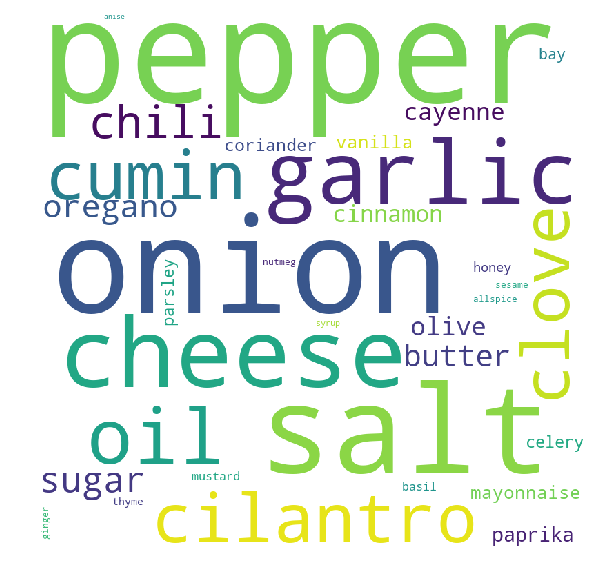

In [279]:
plt_wordcloud(data)

## 1.4 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [331]:
method_list = [
    'bake',
    'barbecue',
    'blanch',
    'blend',
    'boil',
    'braise',
    'brine',
    'broil',
    'caramelize',
    'combine',
    'crock pot',
    'crush',
    'deglaze',
    'devein',
    'dice',
    'distill',
    'drain',
    'emulsify',
    'ferment',
    'freez',
    'fry',
    'grate',
    'griddle',
    'grill',
    'knead',
    'leaven',
    'marinate',
    'mash',
    'melt',
    'microwave',
    'parboil',
    'pickle',
    'poach',
    'pour',
    'pressure cook',
    'puree',
    'refrigerat',
    'roast',
    'saute',
    'scald',
    'scramble',
    'shred',
    'simmer',
    'skillet',
    'slow cook',
    'smoke',
    'smooth',
    'soak',
    'sous-vide',
    'steam',
    'stew',
    'strain',
    'tenderize',
    'thicken',
    'toast',
    'toss',
    'whip',
    'whisk']

In [332]:
recipe_cooking = recipe_country.copy()

In [333]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(ast.literal_eval)

In [334]:
def judge_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [335]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(judge_cooking)

In [336]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [337]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [338]:
recipe_cooking

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients,method
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,[bake]
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,[bake]
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,"[pour, bake, whisk]"
3,amish tomato ketchup for canning,44061,America,North America,190,41706,2002-10-25,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[mix all ingredients& boil for 2 1 / 2 hours ,...",my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[pour, boil]"
4,apple a day milk shake,5289,America,North America,0,1533,1999-12-06,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"[combine ingredients in blender, cover and ble...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4,"[combine, smooth, blend]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93867,zwiebeln salat swiss onion salad,455209,Switzerland,Europe,10,1058097,2011-05-05,"[113.5, 11.0, 17.0, 19.0, 2.0, 24.0, 3.0]",5,"[melt butter in a saucepan, add onions and sau...",adapted from pan american's compete round the ...,"['butter', 'onions', 'flour', 'salt', 'vinegar']",5,"[saute, melt]"
93868,zwiebelsuppe clear german onion soup,61748,Germany,Europe,35,27783,2003-05-08,"[252.0, 17.0, 21.0, 44.0, 21.0, 14.0, 7.0]",10,"[heat oil in a large pot, saute garlic slices ...",this is very different from french onion soup....,"['onions', 'red onions', 'fresh garlic', 'oliv...",11,"[simmer, saute, melt, broil]"
93869,zwiebelwhe swiss onion tart,410985,Switzerland,Europe,165,993604,2010-01-30,"[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"[crust:, pulse flour , baking powder , and sal...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13,"[pour, bake, combine, whisk]"
93870,zydeco sauce,357451,America,North America,15,461283,2009-02-23,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"[to make the sauce , combine the mayonnaise , ...",great sauce for cheeseburgers or dipping fries...,"['mayonnaise', 'prepared horseradish', 'worces...",6,[combine]


In [339]:
recipe_cooking.to_pickle('recipe_cooking.pkl')

In [340]:
recipe_cooking_e = recipe_cooking.explode('method')

In [341]:
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(10)
method_country = method_country.to_frame().droplevel(0).reset_index()  

In [255]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'China']['method'].values

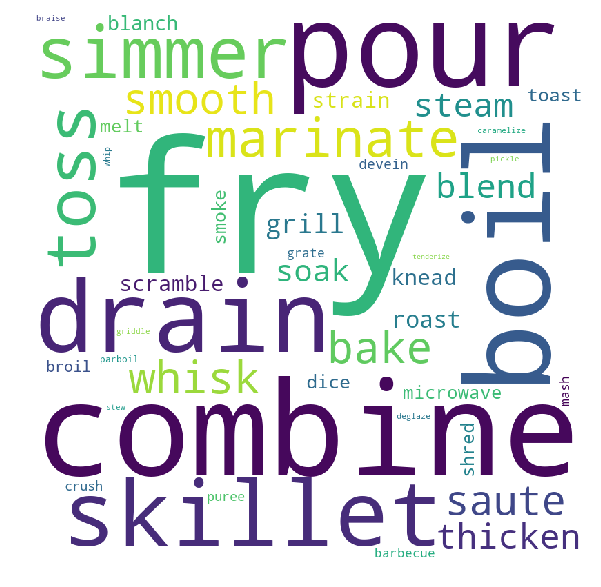

In [256]:
plt_wordcloud(data)

## 1.5 Extract main ingredients for each recipe

As mentioned in section 1.3, main ingredients are extracted. The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 220 various ingredients are identified. 

In [342]:
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']

In [343]:
unions = dairy + vegetable + fruit + meat + seafood + grain

In [344]:
len(unions)

220

In [345]:
ingreds = recipe_c.explode('ingredients')

In [346]:
s_list = re.findall(r"[\w']+", row)
engine = inflect.engine()
r_list = []
for word in s_list:
    if re.search('|'.join(unions), word) is not None:
        if engine.singular_noun(word) is not None:
            word = engine.singular_noun(word)
        if word in unions:
            r_list.append(word)

In [347]:
def judge_ingredients(row):
    s_list = re.findall(r"[\w']+", row)
    engine = inflect.engine()
    r_list = []
    for word in s_list:
        if re.search('|'.join(unions), word) is not None:
            if engine.singular_noun(word) is True:
                word = engine.singular_noun(word)
            if word in unions:
                r_list.append(word)
    return r_list

In [348]:
ingreds['ingredients'] = ingreds['ingredients'].apply(judge_ingredients)

In [349]:
recipe_main = ingreds[ingreds['ingredients'].apply(len) > 0]

In [350]:
recipe_main

,name,id,country,continent,minutes,contributor_id,submitted,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,America,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7
1,arriba baked winter squash mexican style,137739,Mexico,North America,55,47892,2005-09-16,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,[squash],7
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[pizza],6
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[sausage],6
2,a bit different breakfast pizza,31490,America,North America,30,26278,2002-06-17,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,[milk],6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139613,zwiebelwhe swiss onion tart,410985,Switzerland,Europe,165,993604,2010-01-30,"[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,[milk],13
139613,zwiebelwhe swiss onion tart,410985,Switzerland,Europe,165,993604,2010-01-30,"[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,[cream],13
139614,zydeco sauce,357451,America,North America,15,461283,2009-02-23,"[239.9, 30.0, 19.0, 22.0, 1.0, 14.0, 5.0]",3,"['to make the sauce , combine the mayonnaise ,...",great sauce for cheeseburgers or dipping fries...,[horseradish],6
139617,zydeco soup,486161,America,North America,60,227978,2012-08-29,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,[ham],22


In [351]:
recipe_main = recipe_main.explode('ingredients')

In [352]:
ingredient_country = recipe_main.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(50)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()  

In [353]:
ingredient_country

,country,ingredients,id
0,America,cream,41943
1,America,flour,41181
2,America,chicken,37614
3,America,milk,28923
4,America,lemon,20976
...,...,...,...
2797,Vietnam,banana,10
2798,Vietnam,cherry,10
2799,Vietnam,apricot,9
2800,Vietnam,squash,9


In [270]:
america_data = recipe_main[recipe_main['country'] == 'America']['ingredients'].values

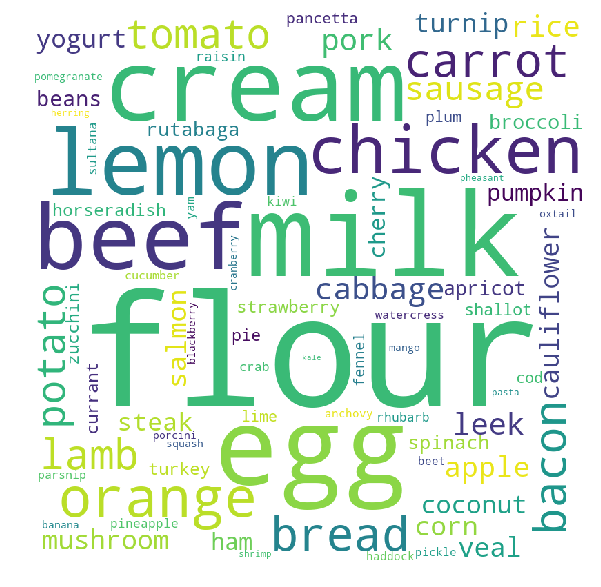

In [269]:
plt_wordcloud(america_data)